# Import modules and define functions

In [1]:
# import modules
from io import BytesIO
import requests
import pandas as pd
from arcgis.features import FeatureLayer
from arcgis.gis import GIS
from arcgis.mapping import WebMap
from arcgis.gis import GIS

In [2]:
# The client_id used for this project
client_id="D6mmWslBBmHA1RuS"

In [3]:
def connect_to_GIS(client_id="D6mmWslBBmHA1RuS"):
    '''
    This function connects to a GIS server and returns an active connection into a connection variable.
    Input variable:
        client_id: optional; default is "D6mmWslBBmHA1RuS"
    '''
    try:
        gis = GIS("https://utoronto.maps.arcgis.com",client_id="D6mmWslBBmHA1RuS", verify_cert=False)
        print("Successfully logged in as: " + gis.properties.user.username)
    except:
        print("Connection error: please check your client_id and internet connection")
    return gis

In [4]:
def get_atlas_dataset(map_id:str, layer:int):
    '''
    Get GIS atlas map dataset. 
    Input variables:
        map_id: str; ID of the atlas map
        layer: int; the layer number interested
    '''
    try:
        subjects_item = gis.content.get(map_id)
    except:
        print("Error: The id is not valid or the connection has been lost. Please try reconnecting to the server.")
    try:    
        subjects_flayer = subjects_item.layers[layer]
        subjects_df = subjects_flayer.query(as_df=True)
        return subjects_df
    except:
        print("Error: Please ensure the layer number is valid for the map.")

In [5]:
def filter_country(df_global, country_name:str):
    '''
    Filter the global covid dataset based on country name.
    Input variables:
        df_global: the global covid dataset
        country_name: str; name of the country interested
    '''
    try: 
        fset_country = df_global[df_global['Country_Region']==country_name]
        if len(fset_country) == 0:
            raise Exception("The country_name is not valid")
        return fset_country
    except:
        print("Error: Check whether the global covid dataset is correct.")

In [6]:
def merge_atlas_and_covid_datasets(fset_country, subjects_df, how:str):
    '''
    Merges the Atlas and Covid datasets.
    Input variables:
        fset_country: the covid dataset filtered based on country
        subjects_df: the Atlas map dataset
        how: the type of joins to make
    '''
    try:
        country_merged = pd.merge(fset_country, subjects_df[['NAME', 'SHAPE']], left_on = "Province_State", \
                             right_on='NAME', how=how)
        country_merged = country_merged.drop(['SHAPE_x'], axis=1).rename(columns={"SHAPE_y": "SHAPE"})
        return country_merged
    except:
        print("Error: Check the column names. Country dataset must have 'Province_State'" \
              " Atlas dataset must have 'NAME' and 'SHAPE'.")

In [7]:
def make_map(country_name:str, merged_dataset, zoom_lvl=4, class_count = 7, legend = False):
    '''
    Makes the map for selected country.
    Input variables:
        country_name: the country of interest
        merged_dataset: merged dataset for the country
        zoom_lvl: optional; zoom level of the map; default is 4
        class_count: optional; class count of the map; default is 7
        legend: optional; whether to display the legend of the map; boolean value; default is False
    '''
    try:
        gis_map = gis.map(country_name, zoomlevel=4)
    except:
        print("Error: Check server connection")
        return
    try:
        merged_dataset.spatial.plot(  kind='map', map_widget=gis_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyStandardDeviation',  # classification algorithm
                                 class_count=class_count,  # choose the number of classes
                                 col='Confirmed',  # numeric column to classify
                                 cmap='inferno',  # color map to pick colors from for each class
                                 alpha=0.7  # specify opacity
                                )
        gis_map.legend = legend
        return gis_map
    except:
        print("Error: Map plot failure. Check dataset validity")
        return

In [8]:
def plot_cases(merged_dataset):
    '''
    Makes bar plot for 'Confirmed','Deaths', 'Recovered' of the selected country.
    Input variables:
        merged_dataset: the merged dataset of the country of interest
    '''
    try:
        plot = merged_dataset.set_index("Province_State")[['Confirmed','Deaths', 'Recovered']].plot.bar()
        return plot
    except:
        print("Error: Plot failure. Check dataset")

## 0. Connect to the GIS server and obtain COVID dataset

In [9]:
# Connects to a GIS server
gis = connect_to_GIS()

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://utoronto.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=D6mmWslBBmHA1RuS&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=dQEfCIHdw5xYOFd1FvF7gqJV2vO7Wo&allow_verification=false
Enter code obtained on signing in using SAML: ········
Successfully logged in as: yangch53_utoronto


In [10]:
# Access Coronavirus COVID-19 (2019-nCoV) ArcGIS Dashboard created by the CSSE Team 
item = gis.content.search("Coronavirus_2019_nCoV_Cases owner:CSSE_covid19", outside_org=True)[0]
src_url = "https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1"
fl = FeatureLayer(url=src_url)

In [11]:
# Take the whole covid dataset and store it in df_global
df_global = fl.query(where="1=1", return_geometry=True, as_df=True)

## 1. Visualization for Australia

In [12]:
country_name = "Australia"                                            # set country name
AU_df = get_atlas_dataset("1eb0511ee53a47b386e98e9c4663127b", 2)      # get the Atlas map from GIS for 
fset_AU = filter_country(df_global, country_name)                     # filter the covid dataset based on the country
AU_merged = merge_atlas_and_covid_datasets(fset_AU, AU_df, "left")    # merge the covid dataset with the Atlas map dataset
AU_merged.head(5)

,OBJECTID,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,Deaths,Active,Admin2,FIPS,Combined_Key,NAME,SHAPE
0,10,Australian Capital Territory,Australia,2022-09-11 05:20:45,-35.4735,149.0124,203680,0,125,0,None,None,"Australian Capital Territory, Australia",Australian Capital Territory,"{""rings"": [[[16600879.9624, -4181065.9785], [1..."
1,11,New South Wales,Australia,2022-09-11 05:20:45,-33.8688,151.2093,3463759,0,5046,0,None,None,"New South Wales, Australia",New South Wales,"{""rings"": [[[16703645.1077, -4475853.0507], [1..."
2,12,Northern Territory,Australia,2022-09-11 05:20:45,-12.4634,130.8456,96447,0,70,0,None,None,"Northern Territory, Australia",Northern Territory,"{""rings"": [[[15259049.6029, -1788024.0168], [1..."
3,13,Queensland,Australia,2022-09-11 05:20:45,-27.4698,153.0251,1620034,0,2048,0,None,None,"Queensland, Australia",Queensland,"{""rings"": [[[17077774.7245, -3240314.4403], [1..."
4,14,South Australia,Australia,2022-09-11 05:20:45,-34.9285,138.6007,758840,0,860,0,None,None,"South Australia, Australia",South Australia,"{""rings"": [[[15658300.314, -4588263.1137], [15..."


In [13]:
# Makes the map
make_map(country_name, AU_merged)

MapView(layout=Layout(height='400px', width='100%'))

<AxesSubplot:xlabel='Province_State'>

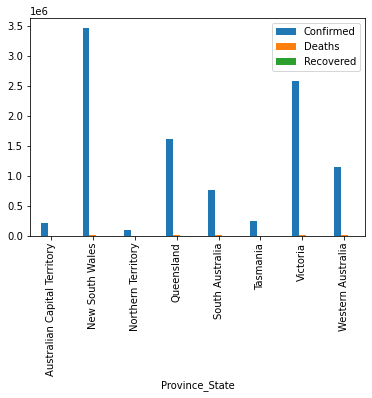

In [14]:
# Plot the confirmed, deaths, Recovered covid cases for the country
plot_cases(AU_merged)

## 2. Visualization for UK

In [15]:
country_name = "United Kingdom"                                       # set country name
UK_df = get_atlas_dataset("605d0bb40f094264bcab01ffb3623347", 1)      # get the Atlas map from GIS for 
fset_UK = filter_country(df_global, country_name)                     # filter the covid dataset based on the country
UK_merged = merge_atlas_and_covid_datasets(fset_UK, UK_df, "inner")   # merge the covid dataset with the Atlas map dataset
UK_merged.head(5)

,OBJECTID,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,Deaths,Active,Admin2,FIPS,Combined_Key,NAME,SHAPE
0,711,England,United Kingdom,2022-09-11 05:20:45,52.3555,-1.1743,19861556,0,174576,0,None,None,"England, United Kingdom",England,"{""rings"": [[[-712342.122900002, 6422971.613], ..."
1,718,Northern Ireland,United Kingdom,2022-09-11 05:20:45,54.7877,-6.4923,713294,0,4831,0,None,None,"Northern Ireland, United Kingdom",Northern Ireland,"{""rings"": [[[-629256.726300001, 7241326.3225],..."
2,720,Scotland,United Kingdom,2022-09-11 05:20:45,56.4907,-4.2026,2095171,0,15588,0,None,None,"Scotland, United Kingdom",Scotland,"{""rings"": [[[-491203.781800002, 7300071.7571],..."
3,723,Wales,United Kingdom,2022-09-11 05:20:45,52.1307,-3.7837,884498,0,10723,0,None,None,"Wales, United Kingdom",Wales,"{""rings"": [[[-347426.047800001, 6688819.4126],..."


In [16]:
# Makes the map
make_map(country_name, UK_merged, zoom_lvl=6, legend=True)

MapView(layout=Layout(height='400px', width='100%'), legend=True)

<AxesSubplot:xlabel='Province_State'>

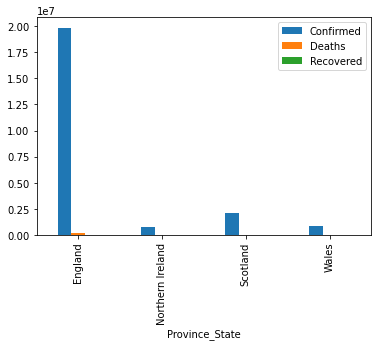

In [17]:
# Plot the confirmed, deaths, Recovered covid cases for the country
plot_cases(UK_merged)